In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/DATA SET/augISIC3Class/base_dir.zip', 'r')
zip_ref.extractall('/content/base_dir')
zip_ref.close()

In [13]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, roc_auc_score, roc_curve, auc
from scipy.stats import hmean, gmean
from tensorflow.keras.models import load_model

# Define your model and training process here

# Define your validation dataset
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/base_dir/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)

# Normalize the validation data
def process(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

validation_ds = validation_ds.map(process)

# Make predictions on the validation dataset
y_true = []
y_pred_probs = []

# Load and predict with both models
efficientnet_model = load_model('/content/drive/MyDrive/Trained Models/EfficientNetB0onISICPre3Classes/best_model.h5')
resnet_model = load_model('/content/drive/MyDrive/Trained Models/ResNet50onISICPre3Classes/best_model.h5')

# Weighted averaging
weight_efficientnet = 0.65
weight_resnet = 1 - weight_efficientnet

for images, labels in validation_ds:
    y_true.extend(tf.argmax(labels, axis=1).numpy())  # True labels

    efficientnet_predictions = efficientnet_model.predict(images)
    resnet_predictions = resnet_model.predict(images)

    predictions = (weight_efficientnet * efficientnet_predictions + weight_resnet * resnet_predictions)
    y_pred_probs.extend(predictions)  # Predicted probabilities

# Convert predicted probabilities to class labels
y_pred = [tf.argmax(prob).numpy() for prob in y_pred_probs]

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# True Positives, False Positives, True Negatives, False Negatives
tp = confusion[1, 1]
fp = confusion[0, 1]
tn = confusion[0, 0]
fn = confusion[1, 0]

# Sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Precision
precision = tp / (tp + fp)

# F1-Score
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

# Error Rate
error_rate = (fp + fn) / (tp + fp + tn + fn)

# Matthews Correlation Coefficient
matthews_corr = matthews_corrcoef(y_true, y_pred)

# Geometric Mean
geometric_mean = gmean([sensitivity, specificity])

# Bookmaker Informedness
bookmaker_informedness = sensitivity + specificity - 1

# Display the metrics
print("Confusion Matrix:")
print(confusion)
print("Accuracy:", (tp + tn) / (tp + tn + fp + fn))
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("F1-Score:", f1_score)
print("Precision:", precision)
print("Error Rate:", error_rate)
print("Matthews Correlation Coefficient:", matthews_corr)
print("Geometric Mean:", geometric_mean)
print("Bookmaker Informedness:", bookmaker_informedness)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Found 648 files belonging to 3 classes.
1/1 [==============================] - 1s 886ms/step
Confusion Matrix:
[[245   6   2]
 [ 12 336   2]
 [ 11   5  29]]
Accuracy: 0.9699499165275459
Sensitivity: 0.9655172413793104
Specificity: 0.9760956175298805
F1-Score: 0.9739130434782608
Precision: 0.9824561403508771
Error Rate: 0.03005008347245409
Matthews Correlation Coefficient: 0.893334586694576
Geometric Mean: 0.970792020960146
Bookmaker Informedness: 0.941612858909191
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       253
           1       0.97      0.96      0.96       350
           2       0.88      0.64      0.74        45

    accuracy                           0.94       648
   macro avg       0.92      0.86      0.88       648
weighted avg       0.94      0.94      0.94       648



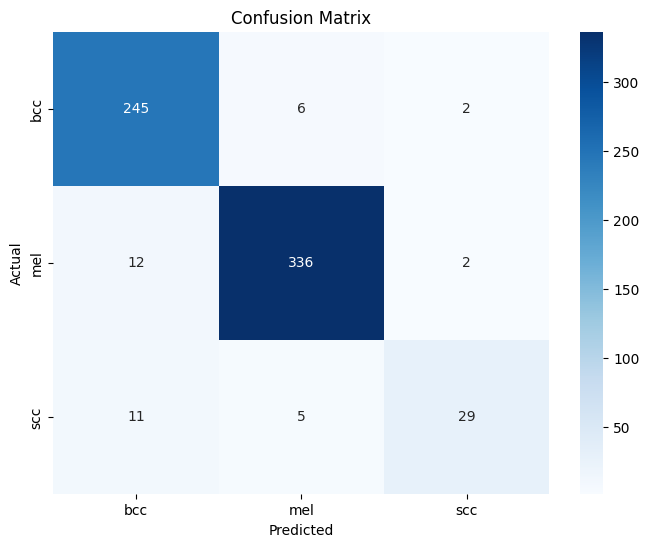

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Define your class names
class_names = ['bcc', 'mel', 'scc']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,  # Use class names as x-axis labels
            yticklabels=class_names)  # Use class names as y-axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Define a function to preprocess an image
def preprocess_image(image_path):
    # Load and preprocess the image (you might need to adjust preprocessing based on your training data)
    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Make predictions on a new image
image_path = '/content/base_dir/val/Melanoma/ISIC_0000155_downsampled.jpg'
preprocessed_image = preprocess_image(image_path)

# Predict with both models
efficientnet_predictions = efficientnet_model.predict(preprocessed_image)
resnet_predictions = resnet_model.predict(preprocessed_image)

# Weighted averaging
weight_efficientnet = 0.6
weight_resnet = 1 - weight_efficientnet

ensemble_predictions = (weight_efficientnet * efficientnet_predictions + weight_resnet * resnet_predictions)

# Interpret the predictions to determine the class
class_names = ['bcc', 'mel', 'scc']  # Replace with your class names
predicted_class_index = np.argmax(ensemble_predictions, axis=1)[0]
predicted_class = class_names[predicted_class_index]

print(f'The ensemble predicts that the image belongs to class: {predicted_class}')

1/1 [==============================] - 0s 57ms/step
The ensemble predicts that the image belongs to class: mel


In [17]:
efficientnet_predictions

array([[1.5930761e-17, 1.0000000e+00, 1.2909347e-24]], dtype=float32)

In [18]:
resnet_predictions

array([[1.7518534e-12, 1.0000000e+00, 5.6030662e-12]], dtype=float32)

In [16]:
ensemble_predictions

array([[7.0075093e-13, 1.0000000e+00, 2.2412265e-12]], dtype=float32)